# Library

In [1]:
#Library Image
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
from scipy import io as sio
import pandas as pd
# import imageio

# tensorflow
import tensorflow as tf
# from tensorflow.compat.v1.layers import dense
# tf.compat.v1.disable_eager_execution()

#machine learning
from skimage import color
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn_nature_inspired_algorithms.model_selection import NatureInspiredSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

# Measurement

In [2]:
def normalize(data):
    meanv = np.mean(data, axis=0)
    stdv = np.std(data, axis=0)

    delta = data - meanv
    data = delta / stdv

    return data

In [4]:
def cva(X, Y):
    diff = X - Y
    diff_s = (diff**2).sum(axis=-1)

    return np.sqrt(diff_s)

In [5]:
def score_assessment(GT, binss):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    from sklearn.metrics import roc_auc_score, balanced_accuracy_score
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
    from sklearn.metrics import precision_score, recall_score, average_precision_score
    from sklearn.metrics import f1_score, precision_recall_curve, auc, classification_report

    print("comfusion matrix = ")
    print(confusion_matrix(GT.reshape(binss.shape), binss))
    cm = confusion_matrix(GT.reshape(binss.shape), binss)
    (tn,fp,fn,tp) = confusion_matrix(GT.reshape(binss.shape), binss).ravel()
    
    print("")
    accuracy = accuracy_score(GT.reshape(binss.shape), binss)
    print('accuracy_score = ', np.round(accuracy,4))
    bas = balanced_accuracy_score(GT.reshape(binss.shape), binss)
    print('balanced_accuracy_score = ', np.round(bas,4))
    kappa_co = cohen_kappa_score(GT.reshape(binss.shape), binss)
    print('kappa = ', np.round(kappa_co,4))
    
    print("")
    precision = precision_score(GT.reshape(binss.shape), binss)
    recall = recall_score(GT.reshape(binss.shape), binss)
    aps = average_precision_score(GT.reshape(binss.shape), binss)
    print ("precision score = ", np.round(precision,4))
    print ("average precision score = ", np.round(aps,4))
    print ("recall score = ", np.round(recall,4))

    print("")
    f1 = f1_score(GT.reshape(binss.shape), binss)
    print ("F1 score = ", np.round(f1,4))
    precision, recall, thresholds = precision_recall_curve(GT.reshape(binss.shape), binss)
    aucs = auc(recall, precision)
    print ("AUC of Precision-Recall Curve on Testing = ", np.round(aucs,4))
    aucroc = roc_auc_score(GT.reshape(binss.shape), binss)
    print ("AUC of ROC = ", np.round(aucroc,4))
#     gini = aucs*2 - 1
#     print("Gini = ", np.round(gini,4))
    
    print("")
    cr = classification_report(GT.reshape(binss.shape), binss)
    print("classification_report")
    print(cr)

#     print("")
#     plt.step(recall, precision, color='k', alpha=0.7, where='post')
#     plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
    
#     fpr, tpr, thresholds = roc_curve(GT.reshape(binss.shape), binss)
#     areaUnderROC = auc(fpr, tpr)

#     plt.figure()
#     plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
#     plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
#     plt.legend(loc="lower right")
#     plt.show()


# Model 

In [6]:
def SFA(X, Y):
    norm_flag = True
    m, n = np.shape(X)
    meanX = np.mean(X, axis=0)
    meanY = np.mean(Y, axis=0)

    stdX = np.std(X, axis=0)
    stdY = np.std(Y, axis=0)

    Xc = (X - meanX) / stdX
    Yc = (Y - meanY) / stdY

    Xc = Xc.T
    Yc = Yc.T

    A = np.matmul((Xc-Yc), (Xc-Yc).T)/m
    B = (np.matmul(Yc, Yc.T)+np.matmul(Yc, Yc.T))/2/m

    D, V = scipy.linalg.eig(A, B)  # V is column wise
    D = D.real

    if norm_flag is True:
        aux1 = np.matmul(np.matmul(V.T, B), V)
        aux2 = 1/np.sqrt(np.diag(aux1))
        V = V * aux2

    X_trans = np.matmul(V.T, Xc).T
    Y_trans = np.matmul(V.T, Yc).T

    return X_trans, Y_trans

In [7]:
class DSFANet(object):
    def __init__(self, num,output_num,hidden_num,layers,reg):
        self.num = num
        self.output_num = output_num
        self.hidden_num = hidden_num
        self.layers = layers
        self.reg = reg
        self.activation = tf.nn.softsign
        self.init = tf.initializers.he_normal()
        
        print(num,output_num,hidden_num,layers,reg)

    def DSFA(self, X, Y):
        X_hat = X - tf.reduce_mean(X, axis=0)
        Y_hat = Y - tf.reduce_mean(Y, axis=0)

        differ = X_hat - Y_hat

        A = tf.matmul(differ, differ, transpose_a=True)
        A = A/self.num

        Sigma_XX = tf.matmul(X_hat, X_hat, transpose_a=True)
        Sigma_XX = Sigma_XX / self.num + self.reg * tf.eye(self.output_num)
        Sigma_YY = tf.matmul(Y_hat, Y_hat, transpose_a=True)
        Sigma_YY = Sigma_YY / self.num + self.reg * tf.eye(self.output_num)

        B = (Sigma_XX+Sigma_YY)/2

        # For numerical stability.
        D_B, V_B = tf.linalg.eigh(B)
        idx = tf.where(D_B > 1e-12)[:, 0]
        D_B = tf.gather(D_B, idx)
        V_B = tf.gather(V_B, idx, axis=1)
        B_inv = tf.matmul(tf.matmul(V_B, tf.linalg.tensor_diag(tf.math.reciprocal(D_B))), tf.compat.v1.transpose(V_B))

        Sigma = tf.matmul(B_inv, A)
        loss = tf.linalg.trace(tf.compat.v1.matmul(Sigma, Sigma))

        return loss

    def forward(self, X, Y):

        for k in range(self.layers):
            X = tf.keras.layers.Dense( units=self.hidden_num, activation=self.activation, use_bias=True,)(X)
            Y = tf.keras.layers.Dense( units=self.hidden_num, activation=self.activation, use_bias=True,)(Y)

        self.X_ = tf.keras.layers.Dense( units=self.output_num, activation=self.activation, use_bias=True,)(X)
        self.Y_ = tf.keras.layers.Dense( units=self.output_num, activation=self.activation, use_bias=True,)(Y)

        loss = self.DSFA(self.X_, self.Y_)

        return loss

# Load dataset

In [8]:
def load_dataset(path1,path2,gt_path,img_data_1,img_data_2,gt_data,norm_flag=True):

    imgX = sio.loadmat(path1)[img_data_1]
    imgY = sio.loadmat(path2)[img_data_2]

    #flattening
    imgX = np.reshape(imgX, newshape=[-1, imgX.shape[-1]])
    imgY = np.reshape(imgY, newshape=[-1, imgY.shape[-1]])

    GT = sio.loadmat(gt_path)[gt_data]

    if norm_flag:
        X = preprocessing.StandardScaler().fit_transform(imgX)
        Y = preprocessing.StandardScaler().fit_transform(imgY)
#         X = normalize(imgX)
#         Y = normalize(imgY)
    return X, Y, GT

# Main program

In [9]:
def main(path,X, Y, GT, diff,lr,output_num,hidden_num,layers,reg,train_num,max_iters):
    lr = 1e-4
    
    index = np.argsort(diff)
    XData = X[index[0:train_num], :]
    YData = Y[index[0:train_num], :]
    
    tf.compat.v1.disable_eager_execution()
    inputX = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, X.shape[-1]])
    inputY = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, Y.shape[-1]])
    
    model = DSFANet(train_num,output_num,hidden_num,layers,reg)
    loss = model.forward(X=inputX, Y=inputY)

    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.compat.v1.global_variables_initializer()

    gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
    conf = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
    sess = tf.compat.v1.Session(config=conf)

    sess.run(init)

    train_loss = np.zeros(max_iters)

    for k in range(max_iters):
        _, train_loss[k] = sess.run([optimizer, loss], feed_dict={inputX: XData, inputY: YData})
        if k % 100 == 0:
            print('iter %4d, loss is %.4f' % (k, train_loss[k]))

    XTest, YTest = sess.run([model.X_, model.Y_], feed_dict={inputX: X, inputY: Y})
    sess.close()
    
    X_trans, Y_trans = SFA(XTest, YTest)
    diff = X_trans-Y_trans
    diff = diff / np.std(diff, axis=0)

#     plt.imsave(path+'DSFAdiff.png', (diff**2).sum(axis=1).reshape(GT.shape), cmap='gray')
    bins = KMeans(n_clusters=2).fit((diff**2).sum(axis=-1, keepdims=True)).labels_
#     plt.imsave(path+'DSFACD.png', bin.reshape(GT.shape), cmap='gray')

    print('/n accuracy score')
    print(accuracy_score(GT.reshape(-1, 1), bins))
    print(accuracy_score(GT.reshape(-1, 1), 1-bins))

    return (train_loss,diff,bins)

# Main Program

# Path

In [10]:
# path = 'dataset/river/'
# path1 = 'dataset/river/img_t1.mat'
# path2 = 'dataset/river/img_t2.mat'
# img_data_1 = 'im'
# img_data_2 = 'im'
# gt_path = 'dataset/river/cva_ref.mat'
# gt_data = 'cva_ref'
path = 'dataset/flood/'
path1 = 'dataset/flood/Cross-sensor-Bastrop-data'
path2 = 'dataset/flood/Cross-sensor-Bastrop-data'
img_data_1 = 't1_L5'
img_data_2 = 't2_L5'
gt_path = 'dataset/flood/Cross-sensor-Bastrop-data'
gt_data = 'ROI_2'

# Parameter

In [11]:
# lr = 5e-4
# output_num = 6
# hidden_num = 128 #128
# layers = 3
# reg = 5e-4
train_num = 5000
max_iters = 2000
lr = 1e-4
output_num = 6
hidden_num = 128 #128
layers = 2
reg = 1e-4

# Data Visualization

## show random band from pre event

<IPython.core.display.Javascript object>


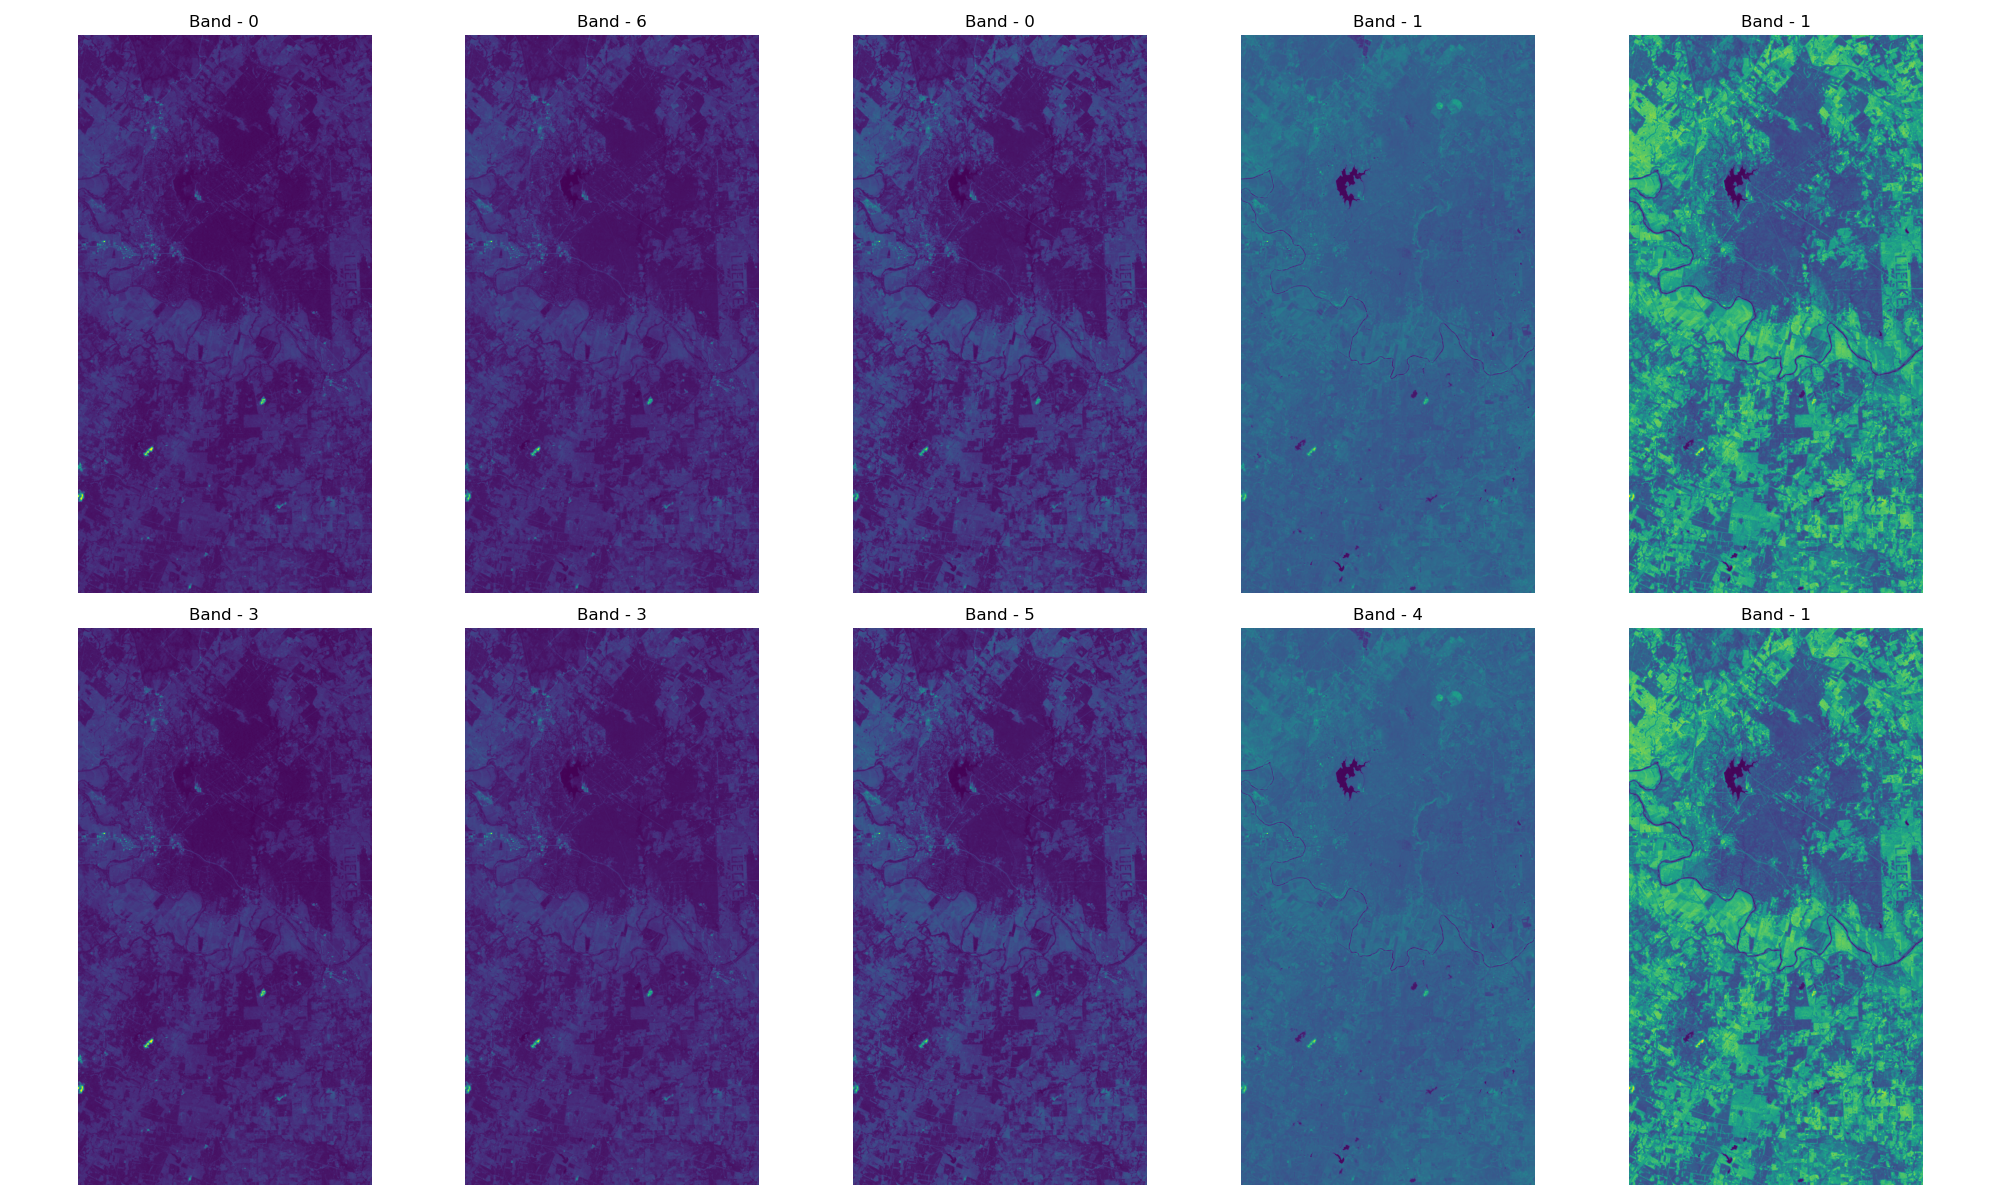

In [15]:
imgX = sio.loadmat(path1)[img_data_1]
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)
# c = [61,23,99,78,89,106,189,182,187,182]
for i in range(2):
    for j in range(5):
        c = np.random.randint(len(imgX[0][0]))
        
        ax[i][j].imshow(imgX[:, :, j])
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()
plt.show()

## show random band from pos event

<IPython.core.display.Javascript object>


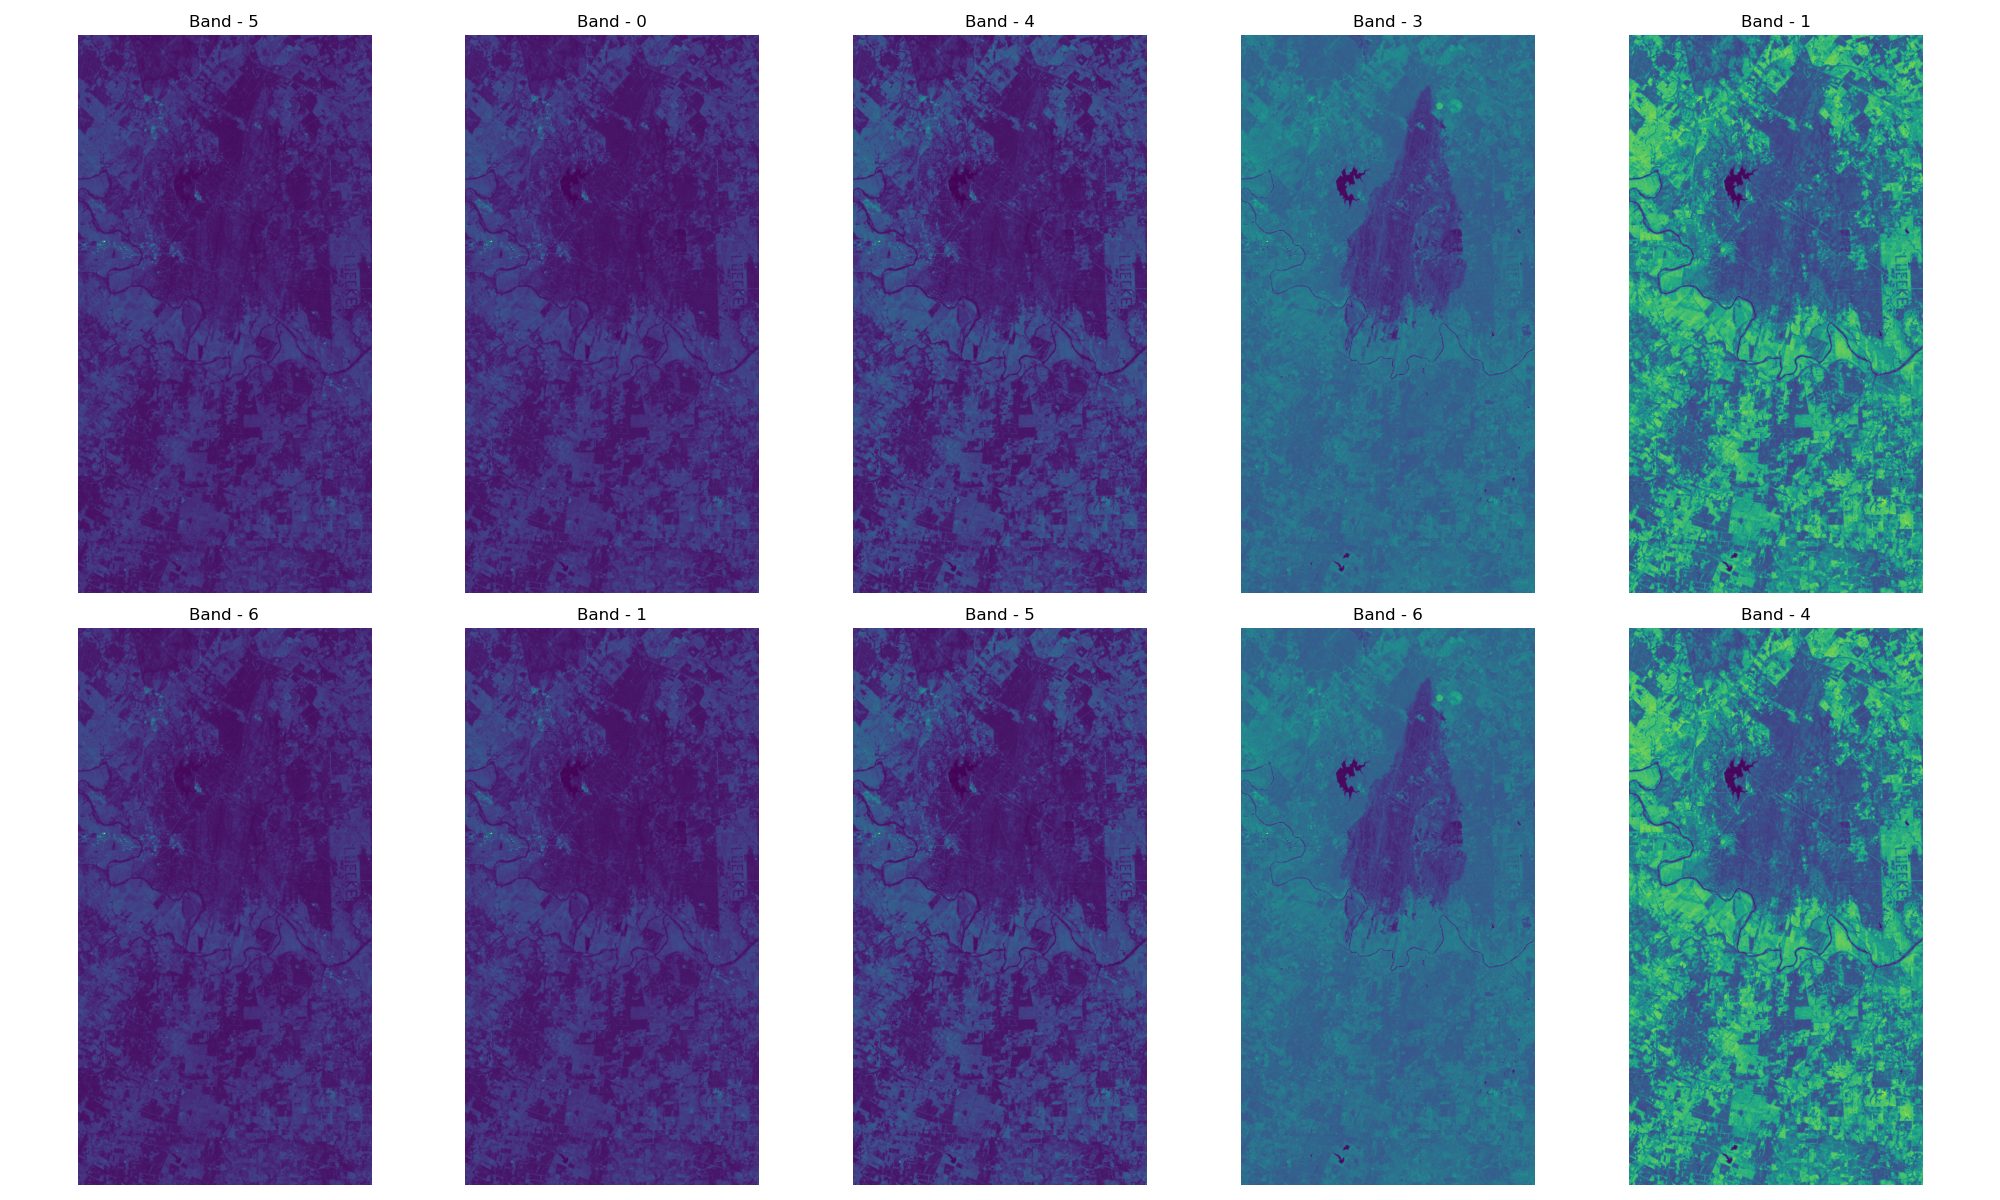

In [16]:
imgY = sio.loadmat(path2)[img_data_2]
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)
# c = [61,23,99,78,89,106,189,182,187,182]
k=0
for i in range(2):
    for j in range(5):
        c = np.random.randint(len(imgY[0][0]))
        ax[i][j].imshow(imgY[:, :, j])
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        k+=1

plt.tight_layout()
plt.show()

# Run the Program

In [14]:
X, Y, GT = load_dataset(path1,path2,gt_path,img_data_1,img_data_2,gt_data)
print(f'Data Shape: {X.shape[:-1]}\nNumber of Bands: {X.shape[-1]}')
diff = cva(X=X, Y=Y)
plt.imsave('cva_diff.png', np.reshape(diff, GT.shape), cmap='gray')
losss,diffs,binss = main(path,X, Y, GT, diff,lr,output_num,hidden_num,layers,reg,train_num,max_iters)

Data Shape: (1239472,)
Number of Bands: 7
5000 6 128 2 0.0001
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


iter    0, loss is 27.8672
iter  100, loss is 0.5784
iter  200, loss is 0.2993
iter  300, loss is 0.2191
iter  400, loss is 0.1774
iter  500, loss is 0.1506
iter  600, loss is 0.1314
iter  700, loss is 0.1170
iter  800, loss is 0.1056
iter  900, loss is 0.0965
iter 1000, loss is 0.0890
iter 1100, loss is 0.0827
iter 1200, loss is 0.0774
iter 1300, loss is 0.0728
iter 1400, loss is 0.0689
iter 1500, loss is 0.0654
iter 1600, loss is 0.0624
iter 1700, loss is 0.0597
iter 1800, loss is 0.0573
iter 1900, loss is 0.0552
/n accuracy score
0.9034774484619257
0.09652255153807428


## save the result

In [26]:
plt.imsave('./%d-%d-%d_single_DSFAdiff.png'  % (hidden_num,layers,reg), (diffs**2).sum(axis=1).reshape(GT.shape), cmap='gray')
plt.imsave('./%d-%d-%d_single_DSFACD.png' % (hidden_num,layers,reg), binss.reshape(GT.shape), cmap='gray')

## scoring

In [101]:
score_assessment(GT,binss)

comfusion matrix = 
[[1092449   38753]
 [  74355   33915]]

accuracy_score =  0.9087
balanced_accuracy_score =  0.6395
kappa =  0.3277

precision score =  0.4667
average precision score =  0.2062
recall score =  0.3132

F1 score =  0.3749
AUC of Precision-Recall Curve on Testing =  0.42
AUC of ROC =  0.6395

classification_report
              precision    recall  f1-score   support

           0       0.94      0.97      0.95   1131202
           1       0.47      0.31      0.37    108270

    accuracy                           0.91   1239472
   macro avg       0.70      0.64      0.66   1239472
weighted avg       0.90      0.91      0.90   1239472



# Grid search for hyperparameter

In [48]:
train_loss =[]
train_diff=[]
train_bins=[]
train_lists = []

X, Y, GT = load_dataset(path1,path2,gt_path,img_data_1,img_data_2,gt_data)
print(f'Data Shape: {X.shape[:-1]}\nNumber of Bands: {X.shape[-1]}')
diff = cva(X=X, Y=Y)
# plt.imsave('cva_diff.png', np.reshape(diff, GT.shape), cmap='gray')

for i in [1e-1, 1e-2, 1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]:
    for j in ([128]):
        for k in ([2]):
            print('param')
            print('%f %d %d'%(i,j,k))
            train_lists.append([i,j,k])
            loss,diffs,bins = main(path,X, Y, GT, diff,lr,output_num,j,k,i,train_num,max_iters)
            train_loss.append(loss)
            train_diff.append(diffs)
            train_bins.append(bins)

Data Shape: (1239472,)
Number of Bands: 7
param
0.100000 128 2
5000 6 128 2 0.1
iter    0, loss is 1.3434
iter  100, loss is 0.0338
iter  200, loss is 0.0121
iter  300, loss is 0.0078
iter  400, loss is 0.0062
iter  500, loss is 0.0053
iter  600, loss is 0.0047
iter  700, loss is 0.0044
iter  800, loss is 0.0041
iter  900, loss is 0.0038
iter 1000, loss is 0.0037
iter 1100, loss is 0.0035
iter 1200, loss is 0.0034
iter 1300, loss is 0.0033
iter 1400, loss is 0.0032
iter 1500, loss is 0.0031
iter 1600, loss is 0.0030
iter 1700, loss is 0.0029
iter 1800, loss is 0.0028
iter 1900, loss is 0.0028
/n accuracy score
0.898343810913034
0.10165618908696607
param
0.010000 128 2
5000 6 128 2 0.01
iter    0, loss is 8.0744
iter  100, loss is 0.4319
iter  200, loss is 0.1799
iter  300, loss is 0.1064
iter  400, loss is 0.0738
iter  500, loss is 0.0560
iter  600, loss is 0.0449
iter  700, loss is 0.0374
iter  800, loss is 0.0321
iter  900, loss is 0.0281
iter 1000, loss is 0.0250
iter 1100, loss is 

In [25]:
acc = []
name = []
for i in range (len(train_lists)):
    plt.imsave('./results/%s-%d-%d_DSFAdiff.png'  % (train_lists[i][0],train_lists[i][1],train_lists[i][2]), (train_diff[i]**2).sum(axis=1).reshape(GT.shape), cmap='gray')
    plt.imsave('./results/%s-%d-%d_DSFACD.png' % (train_lists[i][0],train_lists[i][1],train_lists[i][2]), train_bins[i].reshape(GT.shape), cmap='gray')
    acc.append(accuracy_score(GT.reshape(-1, 1), train_bins[i]))
    name.append(train_lists[i][0])

NameError: name 'train_lists' is not defined

In [81]:
df = pd.DataFrame(
    {'name': name,
     'acc': acc,
     'train_loss': train_loss
    })

In [82]:
df

name       acc                                         train_loss
0  1.000000e-01  0.898344  [1.3434128761291504, 1.276897668838501, 1.2129...
1  1.000000e-02  0.887166  [8.074410438537598, 6.934076309204102, 5.87786...
2  1.000000e-03  0.905118  [23.918346405029297, 21.290008544921875, 17.94...
3  1.000000e-04  0.908543  [29.559040069580078, 26.53696060180664, 22.719...
4  1.000000e-05  0.898589  [36.61530685424805, 34.28050994873047, 31.9332...
5  1.000000e-06  0.896788  [49.705657958984375, 47.39405822753906, 45.577...
6  1.000000e-07  0.906501  [35.814300537109375, 32.825984954833984, 31.56...
7  1.000000e-08  0.922787  [41.793128967285156, 38.296722412109375, 34.76...

C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


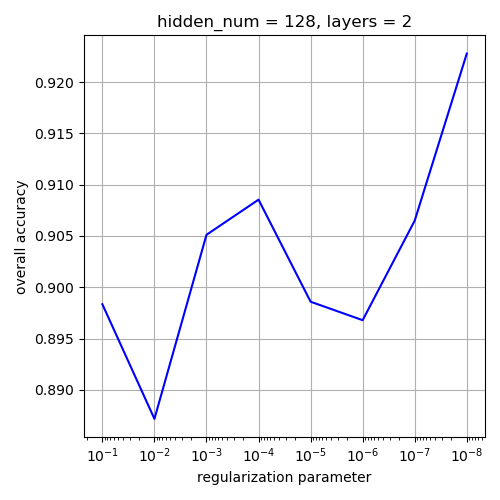

In [83]:
fig,ax = plt.subplots(1,1,figsize = (5, 5))
ax.plot(df['name'],df['acc'],color='b')
ax.set_xscale('log')
ax.grid()
ax.set_title('hidden_num = 128, layers = 2')
ax.set_xlabel('regularization parameter')
ax.set_ylabel('overall accuracy')
ax.invert_xaxis()
plt.tight_layout()
plt.show()

# Comparing result

In [18]:
imgX = sio.loadmat(path1)[img_data_1]
imgY = sio.loadmat(path2)[img_data_2]

GT = sio.loadmat(gt_path)[gt_data]

In [19]:
def biner_image(col_true,col_false,img_gt,flag):
    if (flag=='non_biner'):
        # Threshold image to binary
        img_gt = color.rgb2gray(img_gt)
        thresh = threshold_otsu(img_gt)
        img_gt = img_gt > thresh
    else :
        img_gt = color.rgb2gray(img_gt)
        img_gt = img_gt > 0.5
    # Make 3 channel RGB image same dimensions
    gt = np.zeros((img_gt.shape[0],img_gt.shape[1],3), dtype=np.uint8)

    # Make True pixels red
    gt[img_gt]  = col_true
    # Make False pixels blue
    gt[~img_gt] = col_false
    return(gt)

In [22]:
def plot_result(img_2,gt,result):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 15),
                          sharex=True, sharey=True,frameon=False)
    axes.set_axis_off()
    plt.imshow(img_2)
    plt.imshow(result,alpha=0.7)
    plt.imshow(gt,alpha=1)
    plt.show()

C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


<IPython.core.display.Javascript object>


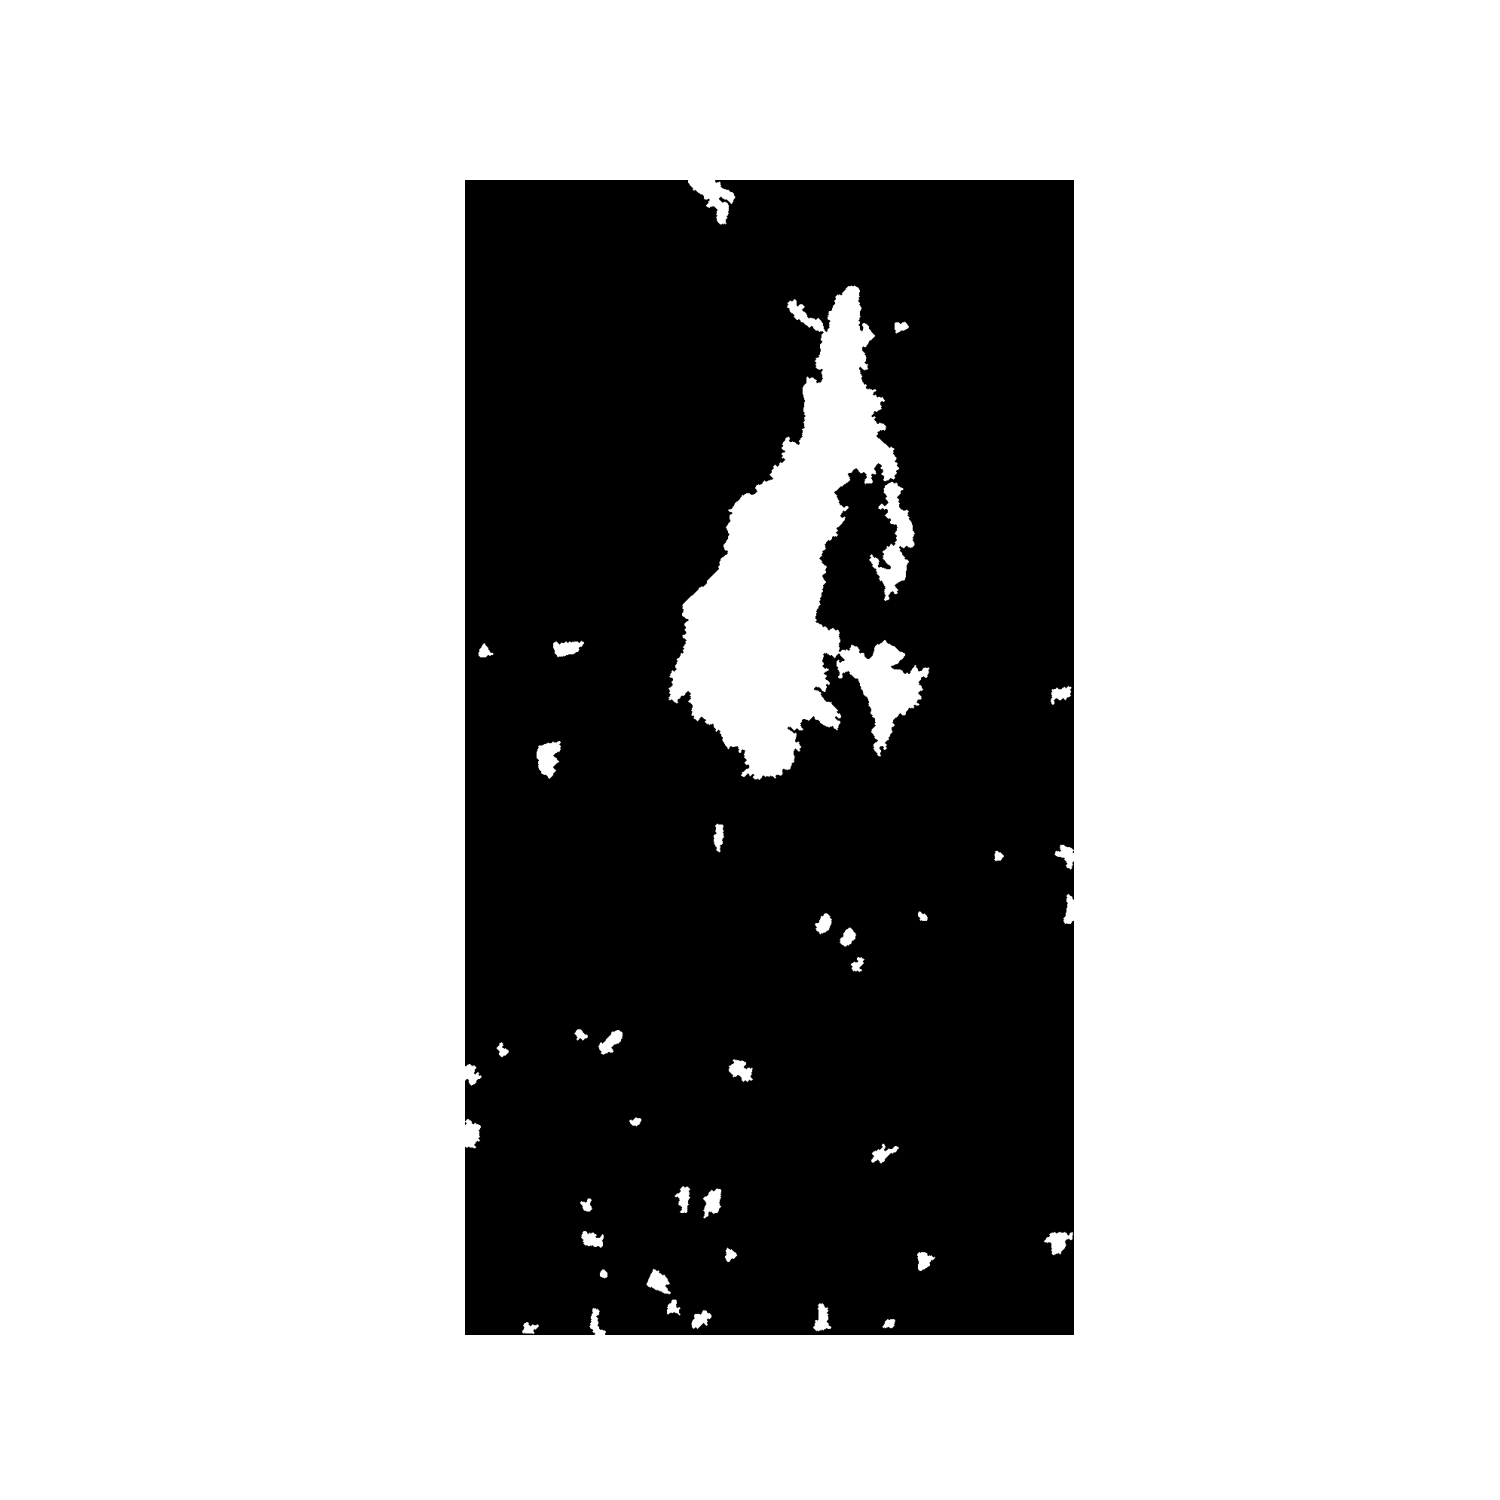

In [23]:
gt = biner_image([255,255,255],[0,0,0],GT,'biner')
re = biner_image([255,0,0],[0,0,0],binss.reshape(GT.shape),'biner')
plot_result(imgY[:, :, 0],gt,re)